# 读取数据

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore') #消除warning

data_raw = pd.read_csv('data.csv')
data_lasso = pd.read_csv('x_lasso.csv')

data_raw['TYPE'] = data_raw['TYPE'].replace(['HCC','Adjacent'],[0,1]) 
X = data_raw.drop(['TYPE','Unnamed: 0','SAMPLE_ID'],axis=1)
y = data_raw['TYPE']
colNames = X.columns
x_raw = StandardScaler().fit_transform(X)    #数据标准化
x_raw = pd.DataFrame(x_raw)
x_raw.columns = colNames 
x_lasso = data_lasso

# 测试集划分

In [2]:
from sklearn.model_selection import train_test_split
xtrain_raw, xtest_raw, ytrain_raw, ytest_raw = train_test_split(x_raw, y, test_size=0.30, random_state=1)
xtrain_lasso, xtest_lasso, ytrain_lasso, ytest_lasso = train_test_split(x_lasso, y, test_size=0.30, random_state=1)

# SMOTE处理

In [3]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smo = SMOTE(random_state=666)
x_smo,y_smo = smo.fit_resample(xtrain_lasso,ytrain_lasso)
#x_smo_raw,y_smo_raw = smo.fit_resample(xtrain_raw,ytrain_raw)
#print(sorted(Counter(ytrain_lasso).items()))
#print(sorted(Counter(y_smo).items()))


# 定义函数

In [4]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def show_scores(y_pred1,y_pred2,y_test):
    print("accuracy_score is:",metrics.accuracy_score(y_test,y_pred1))
    print("roc_auc_score is:",metrics.roc_auc_score(y_test,y_pred2))
    print("precision_score is:",metrics.precision_score(y_test,y_pred1))
    print("recall_score is:",metrics.recall_score(y_test,y_pred1))
    print("f1_score is:",metrics.f1_score(y_test,y_pred1))
    print("classification_report:")
    print(metrics.classification_report(y_test,y_pred1))
    
def plot_roc(y_pred2,y_test,name):
    fpr, tpr, thersholds = roc_curve(y_test, y_pred2, pos_label=1)
    fpr,tpr,threshold = roc_curve(y_test, y_pred2) ###计算真阳率和假阳率
    roc_auc = auc(fpr,tpr) ###计算auc的值
    plt.figure()
    lw = 2
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # for i, value in enumerate(thersholds):
    #     print("%f %f %f" % (fpr[i], tpr[i], value))
    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title(name)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig('./naive_bayes.jpg')#保存图片

def show_confusion_matrix(model,X_test,y_test,y_pred1):
    y_pred = model.predict(X_test)
    confmat = confusion_matrix(y_true=y_test,y_pred=y_pred1)
    fig,ax = plt.subplots(figsize=(2.5,2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()    

# 网格搜索所需要的库

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# 训练模型

决策树

In [ ]:
from sklearn import tree

parameters = {'splitter':('best','random')
              ,'min_samples_leaf':[*range(1,20,2)]
}
tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=7,random_state=25)
GS = GridSearchCV(tree, parameters, cv=10,n_jobs=-1) # cv交叉验证
GS.fit(xtrain_raw,ytrain_raw)
print(GS.best_params_)

#{'min_samples_leaf': 7, 'splitter': 'best'}

In [ ]:
from sklearn import tree
parameters = {'splitter':('best','random')
              ,'criterion':("gini","entropy")
              ,"max_depth":[*range(1,10)]
              ,'min_samples_leaf':[*range(1,20,2)]
}
tree = tree.DecisionTreeClassifier(random_state=25)    
GS = GridSearchCV(tree, parameters, cv=10) # cv交叉验证
GS.fit(xtrain_lasso,ytrain_lasso)
print(GS.best_params_)

#{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5, 'splitter': 'random'}

In [8]:
from sklearn import tree

#clf_raw = tree.DecisionTreeClassifier(criterion='entropy',max_depth=6,min_samples_leaf=7,splitter='best')
#clf_raw = clf_raw.fit(xtrain_raw,ytrain_raw)
#predY_raw1 = clf_raw.predict(xtest_raw)
#predY_raw2 = clf_raw.predict_proba(xtest_raw)[:,1]

clf_lasso = tree.DecisionTreeClassifier()
clf_lasso = clf_lasso.fit(x_smo,y_smo)
predY_lasso1 = clf_lasso.predict(xtest_lasso)
predY_lasso2 = clf_lasso.predict_proba(xtest_lasso)[:,1]

from sklearn.metrics import accuracy_score
#print('rawdata Accuracy on test data is %.2f' % (accuracy_score(ytest_raw, predY_raw1)))
print('lassodata Accuracy on test data is %.2f' % (accuracy_score(ytest_lasso, predY_lasso1)))

lassodata Accuracy on test data is 0.98


accuracy_score is: 0.9833333333333333
roc_auc_score is: 0.9285714285714286
precision_score is: 1.0
recall_score is: 0.8571428571428571
f1_score is: 0.923076923076923
classification_report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       106
           1       1.00      0.86      0.92        14

    accuracy                           0.98       120
   macro avg       0.99      0.93      0.96       120
weighted avg       0.98      0.98      0.98       120



<Figure size 640x480 with 0 Axes>

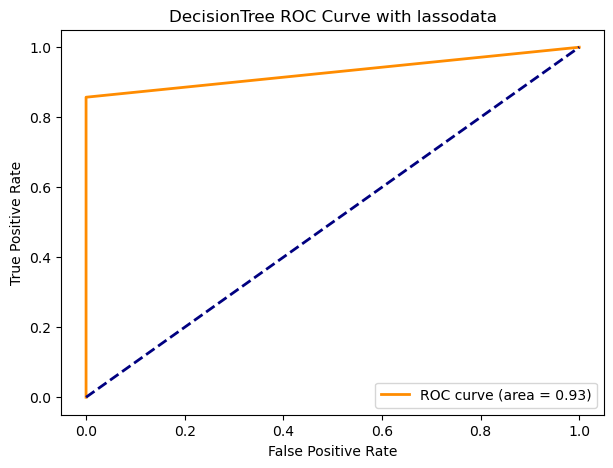

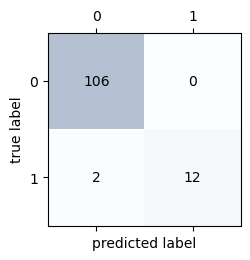

In [9]:
#show_scores(predY_raw1,predY_raw2,ytest_raw)
show_scores(predY_lasso1,predY_lasso2,ytest_lasso)
#plot_roc(predY_raw2,ytest_raw,'DecisionTree ROC Curve with rawdata')
plot_roc(predY_lasso2,ytest_lasso,'DecisionTree ROC Curve with lassodata')
#show_confusion_matrix(clf_raw,xtest_raw,ytest_raw,predY_raw1)
show_confusion_matrix(clf_lasso,xtest_lasso,ytest_lasso,predY_lasso1)

朴素贝叶斯（伯努利）

In [ ]:
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB,ComplementNB,BernoulliNB

parameters={'binarize':[*np.arange(-2.0,2.0,0.1)]
           ,'fit_prior':('True','False')
           ,'alpha': [*np.arange(-2.0,2.0,0.1)]
           }
GS=GridSearchCV(BernoulliNB(),parameters,cv=10,n_jobs=-1)
GS.fit(xtrain_lasso,ytrain_lasso)
print(GS.best_params_) 

In [10]:
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB,ComplementNB,BernoulliNB
NB = BernoulliNB()
NB=NB.fit(x_smo,y_smo)
predY_lasso2=NB.predict_proba(xtest_lasso)[:,1]
predY_lasso1=NB.predict(xtest_lasso)

accuracy_score is: 1.0
roc_auc_score is: 1.0
precision_score is: 1.0
recall_score is: 1.0
f1_score is: 1.0
classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        14

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



<Figure size 640x480 with 0 Axes>

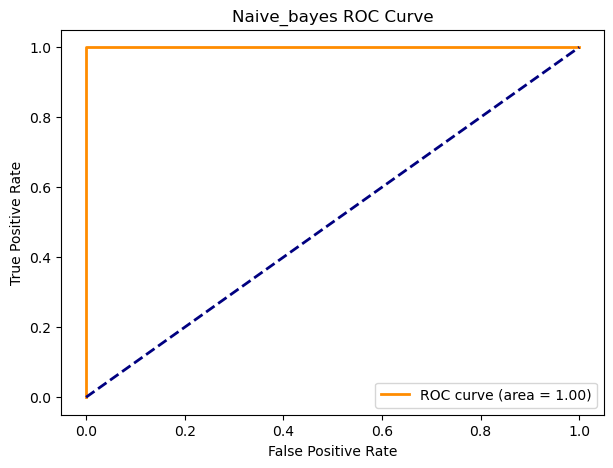

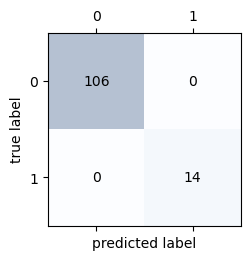

In [11]:
show_scores(predY_lasso1,predY_lasso2,ytest_lasso)
plot_roc(predY_lasso2,ytest_lasso,'Naive_bayes ROC Curve')
show_confusion_matrix(NB,xtest_lasso,ytest_lasso,predY_lasso1)

In [12]:
NB = BernoulliNB ()
NB=NB.fit(xtrain_raw,ytrain_raw)
predY_raw2=NB.predict_proba(xtest_raw)[:,1]
predY_raw1=NB.predict(xtest_raw)

accuracy_score is: 0.9916666666666667
roc_auc_score is: 0.9952830188679246
precision_score is: 0.9333333333333333
recall_score is: 1.0
f1_score is: 0.9655172413793104
classification_report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       106
           1       0.93      1.00      0.97        14

    accuracy                           0.99       120
   macro avg       0.97      1.00      0.98       120
weighted avg       0.99      0.99      0.99       120



<Figure size 640x480 with 0 Axes>

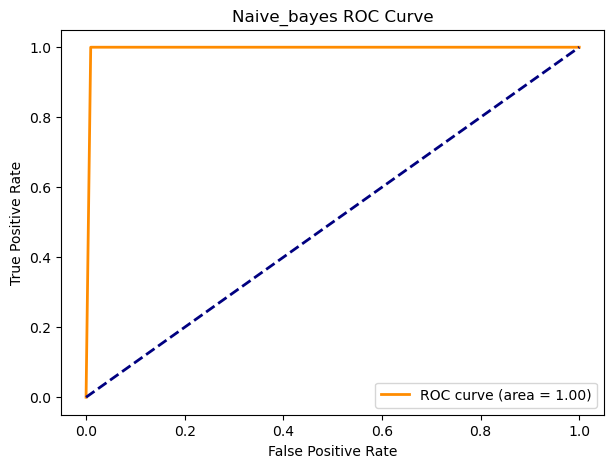

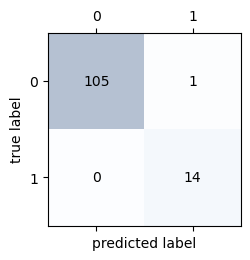

In [13]:
show_scores(predY_raw1,predY_raw2,ytest_raw)
plot_roc(predY_raw2,ytest_raw,'Naive_bayes ROC Curve')
show_confusion_matrix(NB,xtest_raw,ytest_raw,predY_raw1)

### 效果不好，因为lasso数据各属性关联性高，导致过拟合了，NB默认属性是独立的，但对于本数据集来说，显然是不成立的

支持向量机

In [17]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc = svc.fit(x_smo,y_smo)
predY_lasso2=svc.predict_proba(xtest_lasso)[:,1]
predY_lasso1=svc.predict(xtest_lasso)

accuracy_score is: 0.975
roc_auc_score is: 1.0
precision_score is: 1.0
recall_score is: 0.7857142857142857
f1_score is: 0.88
classification_report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       106
           1       1.00      0.79      0.88        14

    accuracy                           0.97       120
   macro avg       0.99      0.89      0.93       120
weighted avg       0.98      0.97      0.97       120



<Figure size 640x480 with 0 Axes>

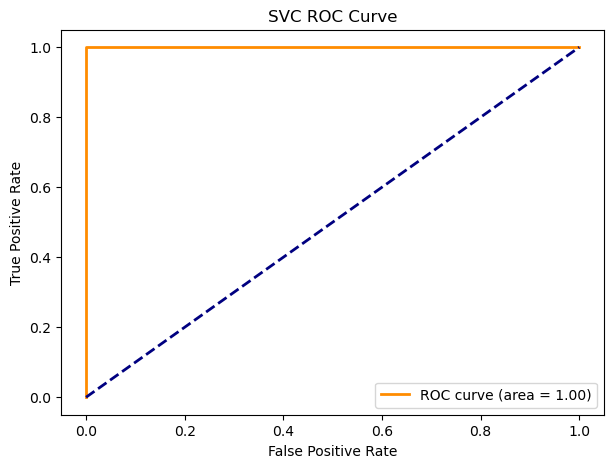

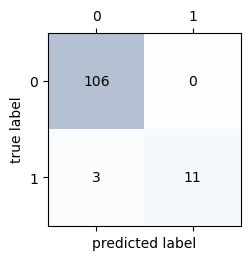

In [18]:
show_scores(predY_lasso1,predY_lasso2,ytest_lasso)
plot_roc(predY_lasso2,ytest_lasso,'SVC ROC Curve')
show_confusion_matrix(svc,xtest_lasso,ytest_lasso,predY_lasso1)

KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=25, metric='minkowski', p=2)
knn = knn.fit(x_smo,y_smo)
predY_lasso2=knn.predict_proba(xtest_lasso)[:,1]
predY_lasso1=knn.predict(xtest_lasso)

accuracy_score is: 0.9916666666666667
roc_auc_score is: 1.0
precision_score is: 0.9333333333333333
recall_score is: 1.0
f1_score is: 0.9655172413793104
classification_report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       106
           1       0.93      1.00      0.97        14

    accuracy                           0.99       120
   macro avg       0.97      1.00      0.98       120
weighted avg       0.99      0.99      0.99       120



<Figure size 640x480 with 0 Axes>

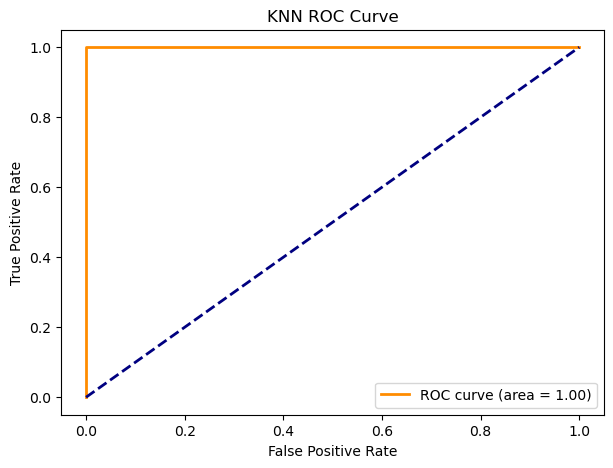

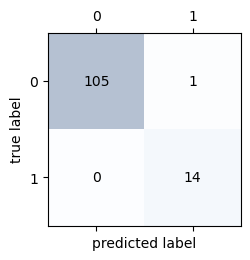

In [27]:
show_scores(predY_lasso1,predY_lasso2,ytest_lasso)
plot_roc(predY_lasso2,ytest_lasso,'KNN ROC Curve')
show_confusion_matrix(knn,xtest_lasso,ytest_lasso,predY_lasso1)

随机森林

In [38]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
rf = ensemble.RandomForestClassifier()
rf = rf.fit(x_smo,y_smo)
predY_lasso2=rf.predict_proba(xtest_lasso)[:,1]
predY_lasso1=rf.predict(xtest_lasso)

accuracy_score is: 1.0
roc_auc_score is: 1.0
precision_score is: 1.0
recall_score is: 1.0
f1_score is: 1.0
classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        14

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



<Figure size 640x480 with 0 Axes>

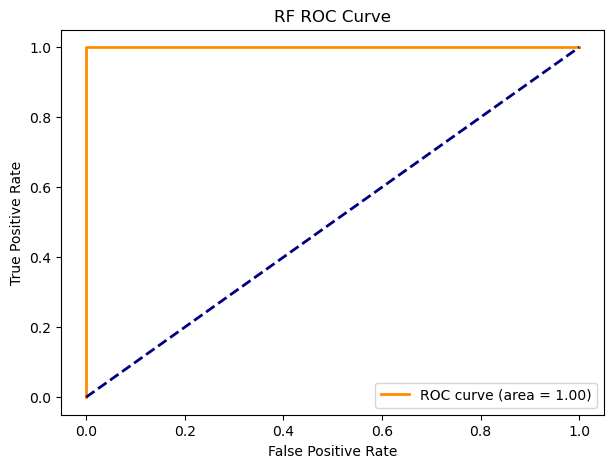

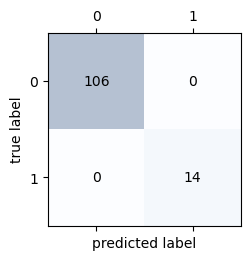

In [39]:
show_scores(predY_lasso1,predY_lasso2,ytest_lasso)
plot_roc(predY_lasso2,ytest_lasso,'RF ROC Curve')
show_confusion_matrix(rf,xtest_lasso,ytest_lasso,predY_lasso1)

AdaBoost

In [32]:
ada = ensemble.AdaBoostClassifier()
ada = ada.fit(x_smo,y_smo)
predY_lasso2=ada.predict_proba(xtest_lasso)[:,1]
predY_lasso1=ada.predict(xtest_lasso)

accuracy_score is: 1.0
roc_auc_score is: 1.0
precision_score is: 1.0
recall_score is: 1.0
f1_score is: 1.0
classification_report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        14

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



<Figure size 640x480 with 0 Axes>

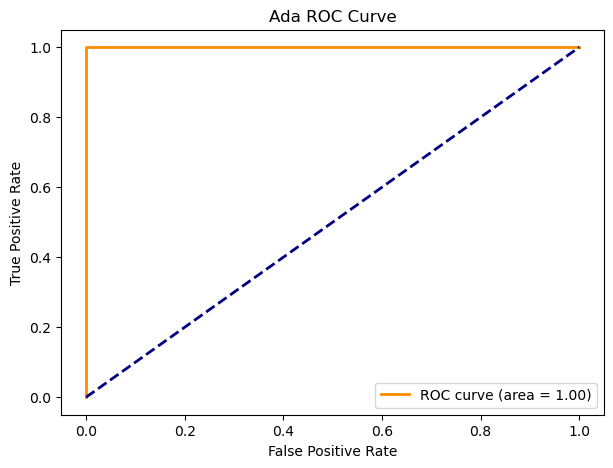

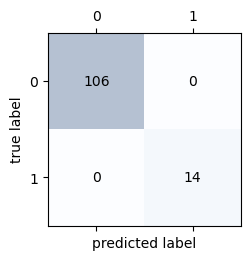

In [33]:
show_scores(predY_lasso1,predY_lasso2,ytest_lasso)
plot_roc(predY_lasso2,ytest_lasso,'Ada ROC Curve')
show_confusion_matrix(ada,xtest_lasso,ytest_lasso,predY_lasso1)